In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
idle = pd.read_csv('data/idle.csv', index_col=0)
#idle0 = idle.iloc[0]['Idle W']
#idle['Idle W'] -= idle0
idle

,Idle W
#Busy,
0,3.836681
1,14.120389
2,16.085455
3,18.313586
4,20.653613
5,23.054486
6,25.757876
7,27.938026
8,30.478582


In [59]:
names = ['#Busy', '#Threads', 'Runtime (s)', 'Usertime (s)', 'Energy (J)']
df = pd.read_csv('data/matmul_cn126.csv', names=names, usecols=[0, 1, 3, 4, 5])

df['Energy (J) w/ idle'] = df['Energy (J)']

user_max = df['Runtime (s)'] * df['#Threads']
user_pct = df['Usertime (s)'] / user_max
user_pct = user_pct.clip(upper=1.0)
df['Usertime (s)'] /= df['#Threads']
df['%User'] = user_pct

# TODO: Somehow subtract artificial BG energy
#df['Energy (J)'] -= df['Runtime (s)'] * idle.iloc[0]['Idle W']
idle_w = df.apply(lambda row: idle.iloc[int(row['#Busy'])]['Idle W'], axis=1)
df['Energy (J)'] -= (1.0 - df['%User']) * df['Runtime (s)'] * idle_w

df['Energy (J) User'] = df['Energy (J)'] * df['%User']

df

,#Busy,#Threads,Runtime (s),Usertime (s),Energy (J),Energy (J) w/ idle,%User,Energy (J) User
0,0,1,0.084861,0.084780,1.317316,1.317624,0.999056,1.316073
1,0,2,0.043099,0.043520,0.880056,0.880056,1.000000,0.880056
2,0,3,0.028635,0.028164,0.718095,0.719901,0.983557,0.706287
3,0,4,0.021710,0.020624,0.633857,0.638022,0.950001,0.602165
4,0,5,0.017482,0.017410,0.595057,0.595332,0.995902,0.592618
...,...,...,...,...,...,...,...,...
267,16,12,0.035114,0.019827,0.964851,1.490348,0.564655,0.544808
268,16,13,0.034099,0.018711,0.907096,1.436058,0.548737,0.497757
269,16,14,0.063391,0.032816,1.437826,2.488871,0.517676,0.744327
270,16,15,0.033998,0.017328,0.840774,1.413836,0.509668,0.428515


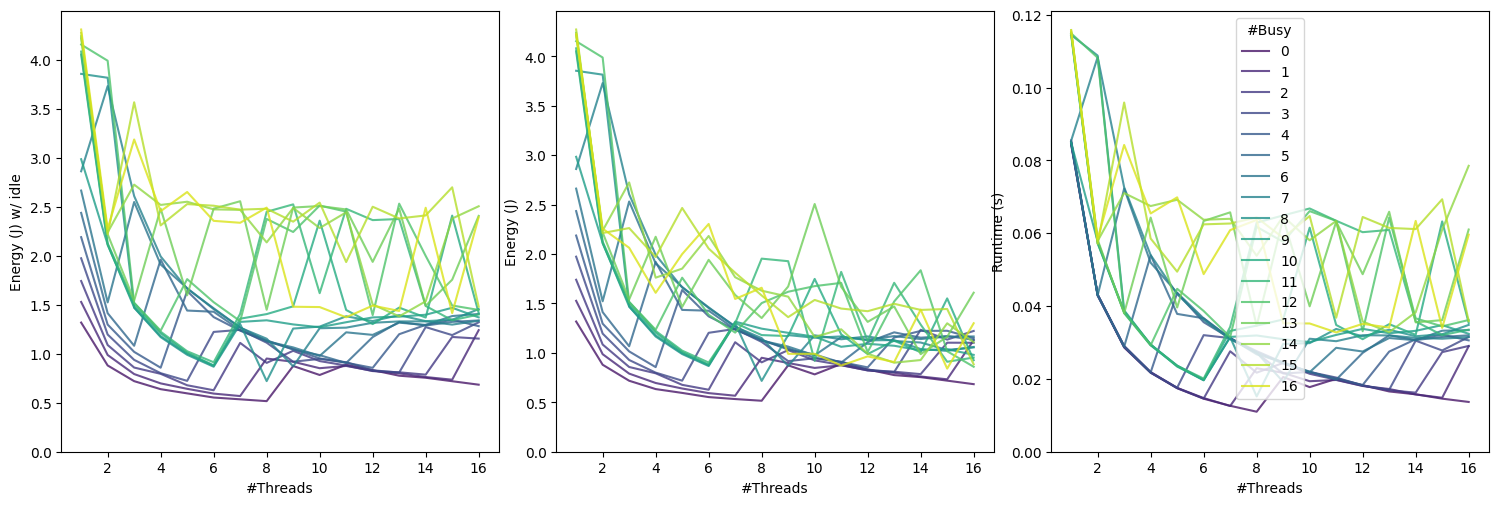

In [60]:
fig, (ax_idle, ax_energy, ax_runtime) = plt.subplots(1, 3, figsize=(15,5))
fig.tight_layout()

hue = df['#Busy'].astype('category')

# Energy
sns.lineplot(df, x='#Threads', y='Energy (J) w/ idle', hue=hue, palette='viridis', alpha=0.8, ax=ax_idle, legend=False)
ax_idle.set_ylim((0, None))

# Energy
sns.lineplot(df, x='#Threads', y='Energy (J)', hue=hue, palette='viridis', alpha=0.8, ax=ax_energy, legend=False)
ax_energy.set_ylim((0, None))

# Runtime
sns.lineplot(df, x='#Threads', y='Runtime (s)', hue=hue, palette='viridis', alpha=0.8, ax=ax_runtime)
ax_runtime.set_ylim((0, None))

plt.show()

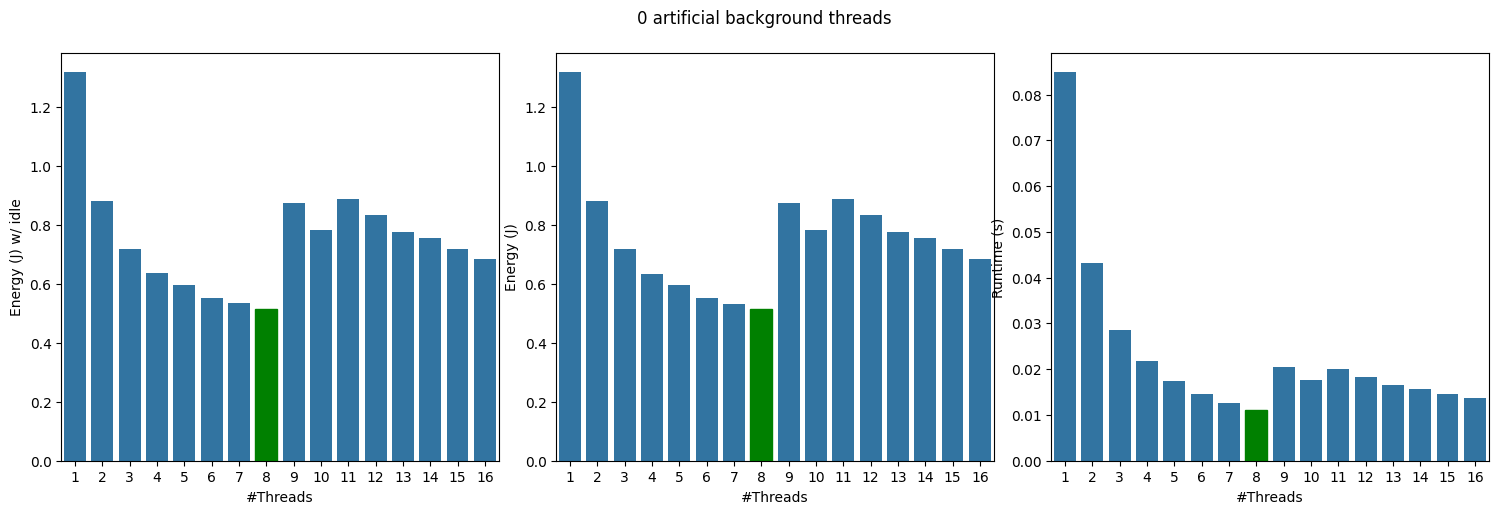

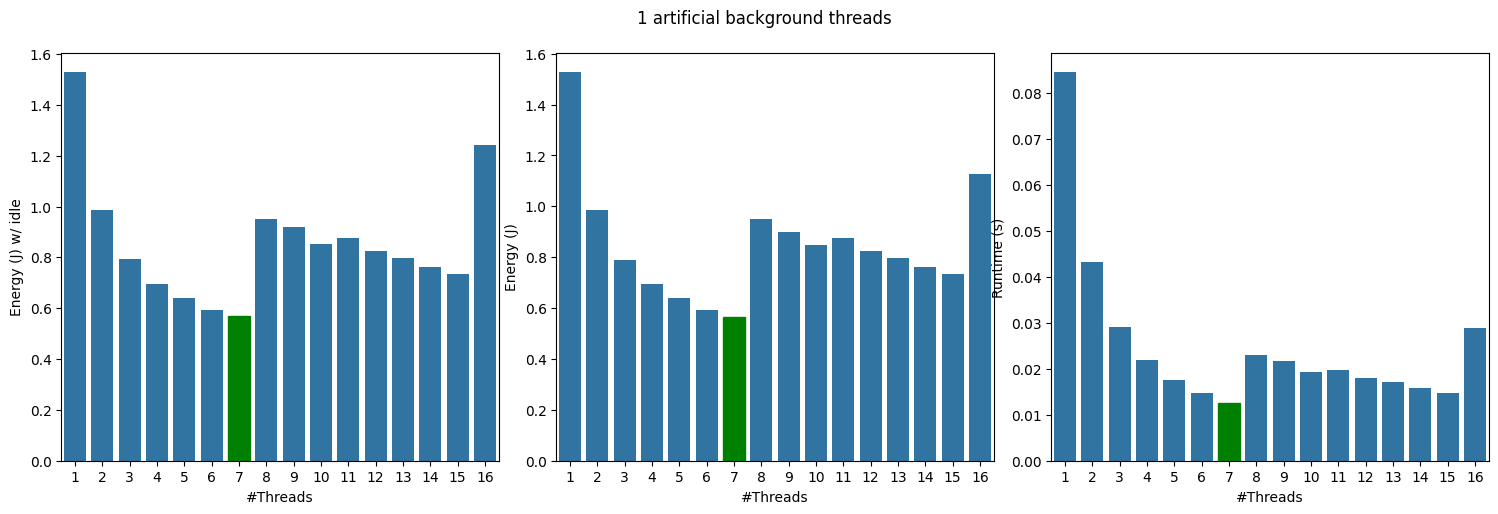

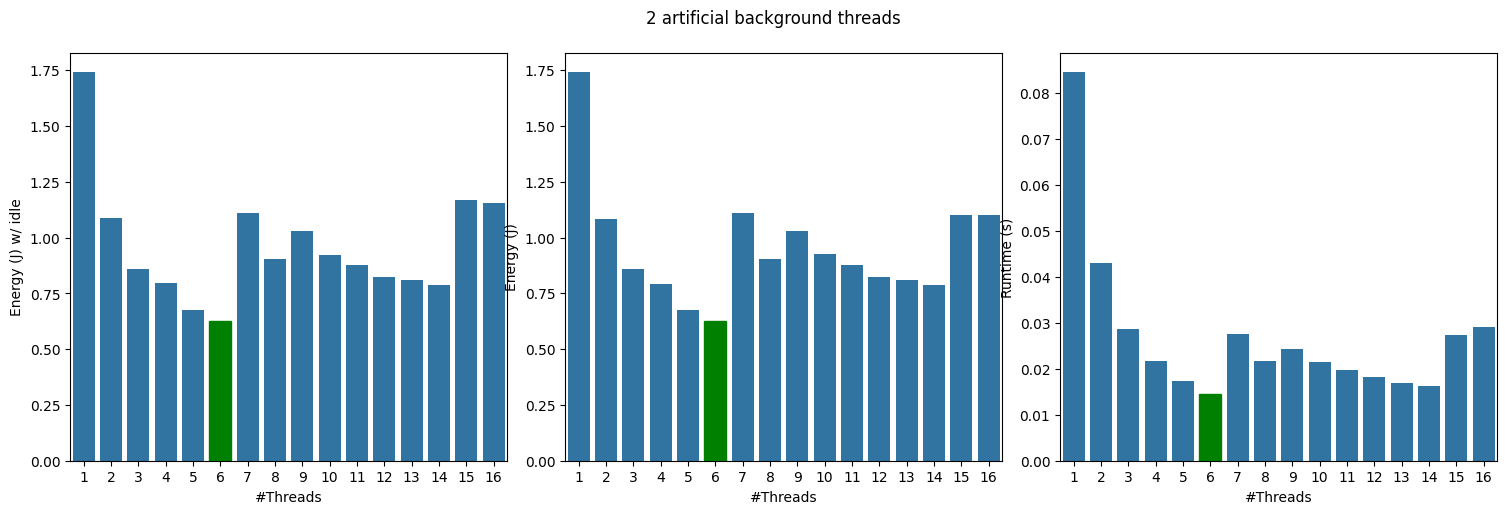

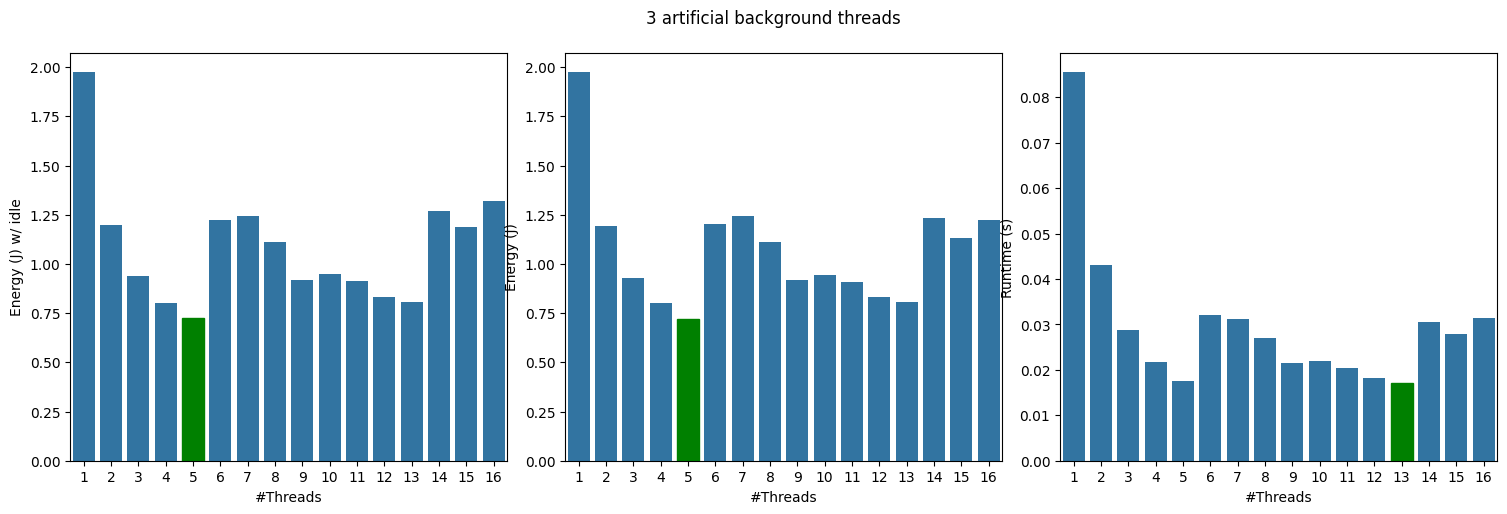

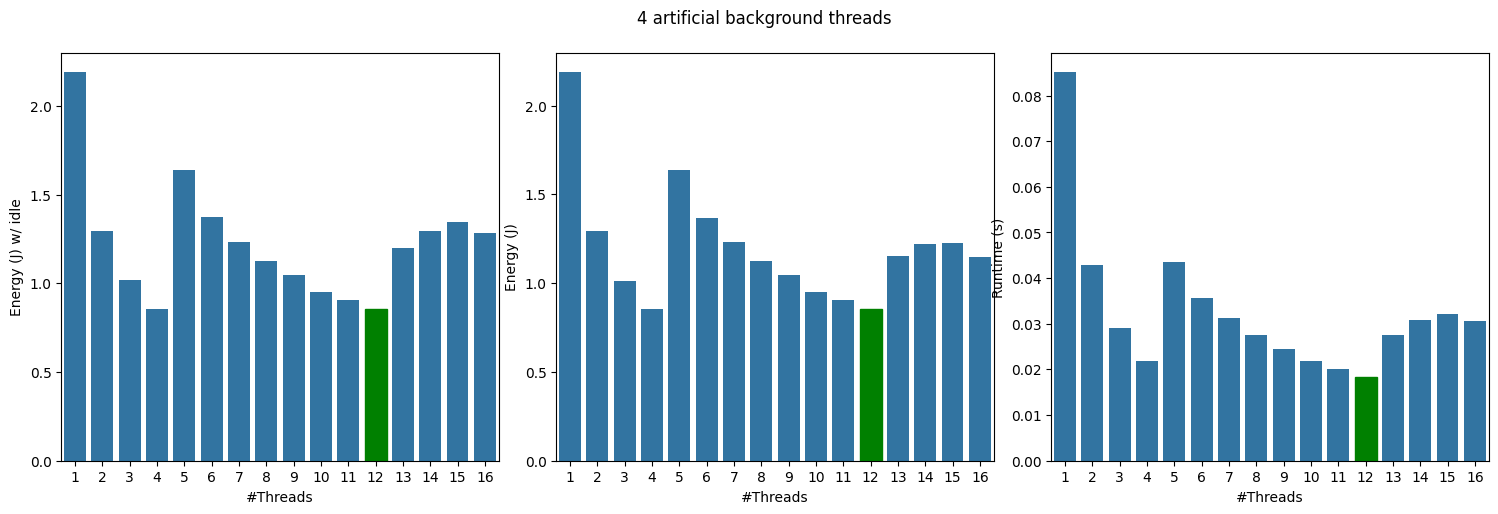

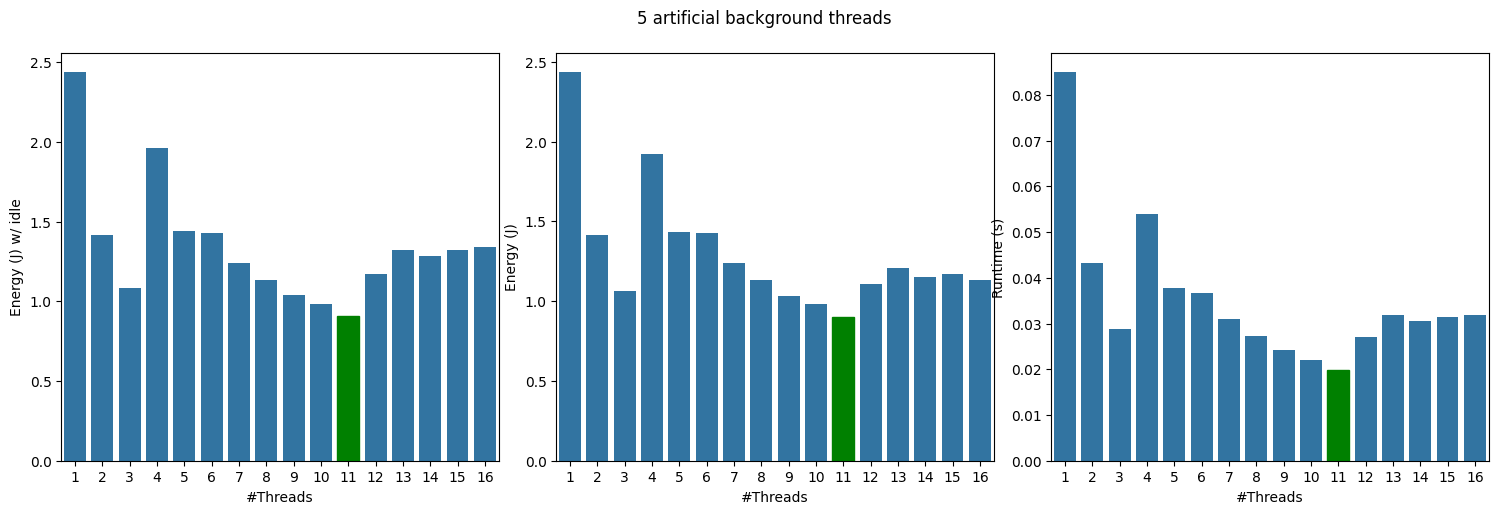

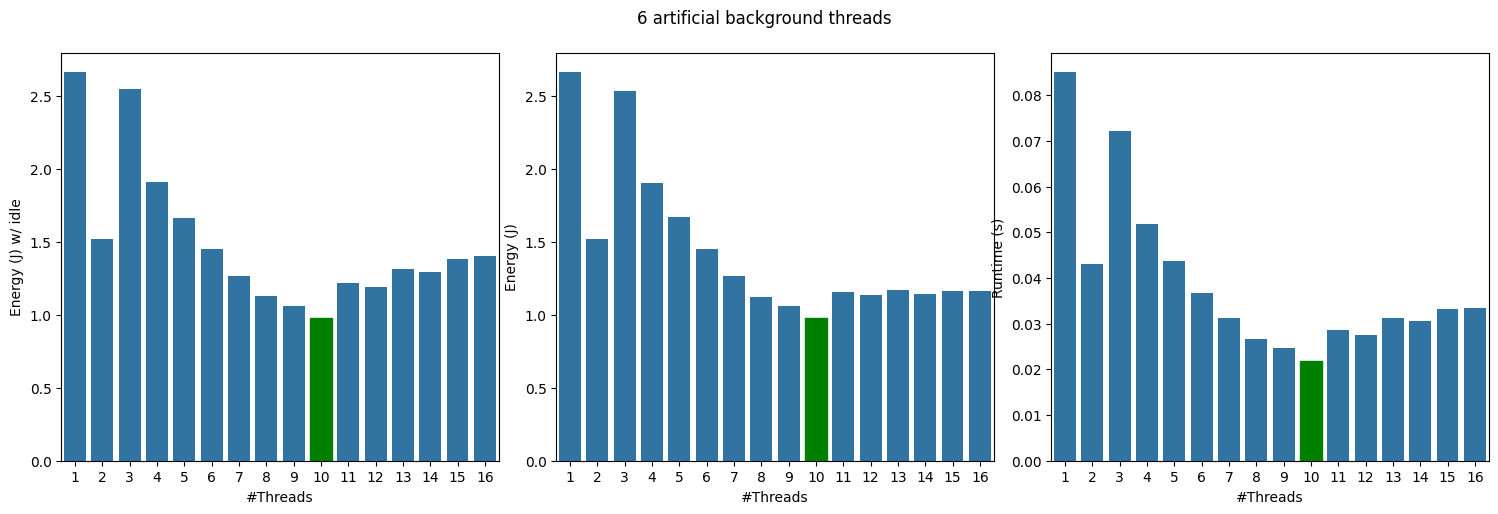

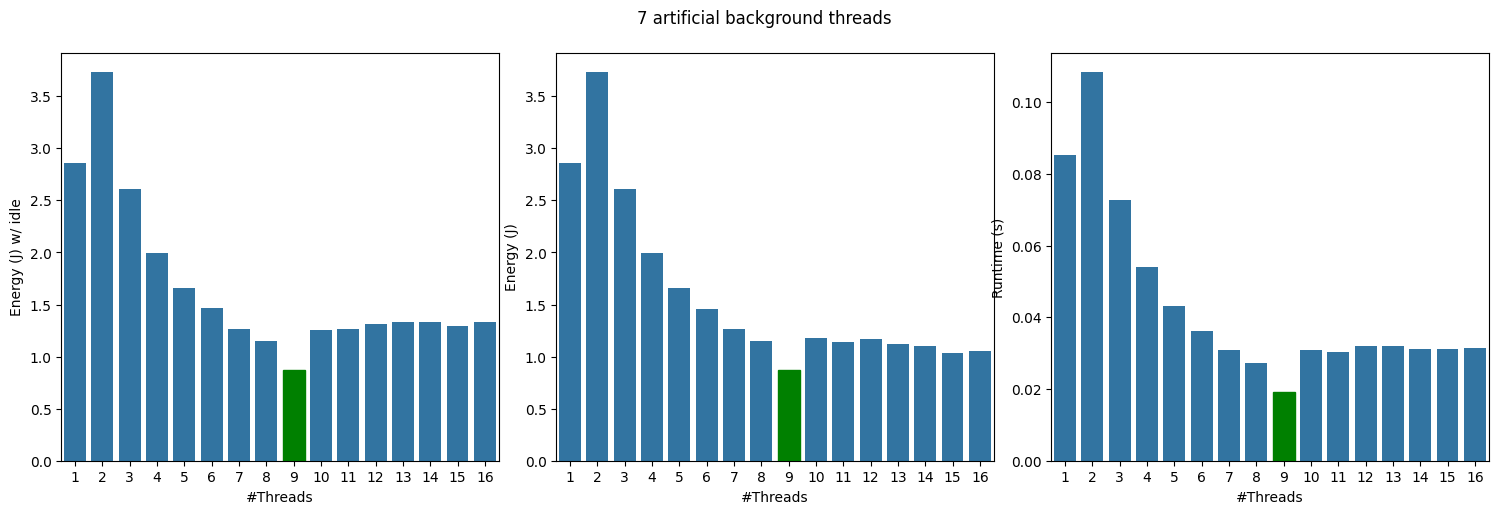

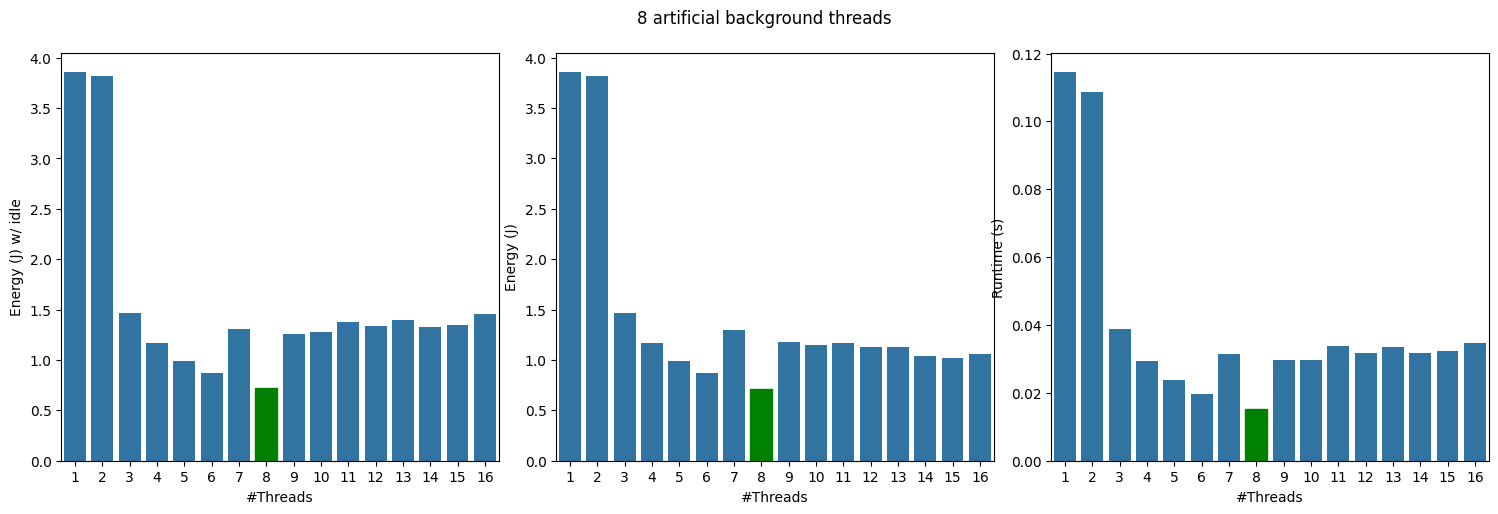

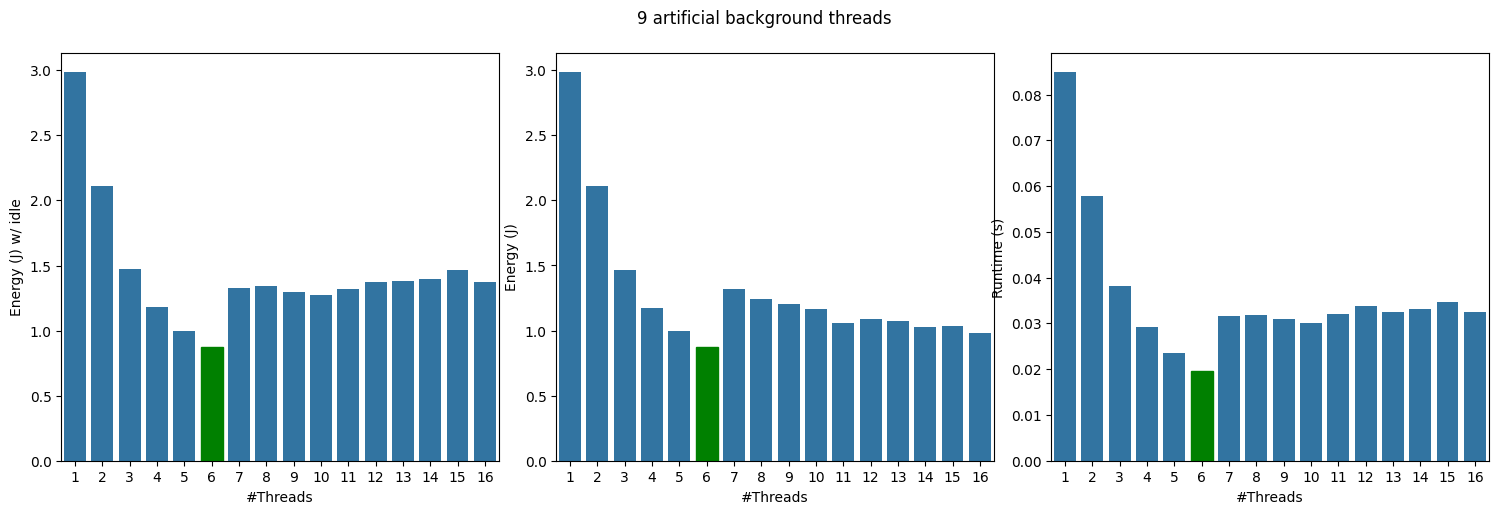

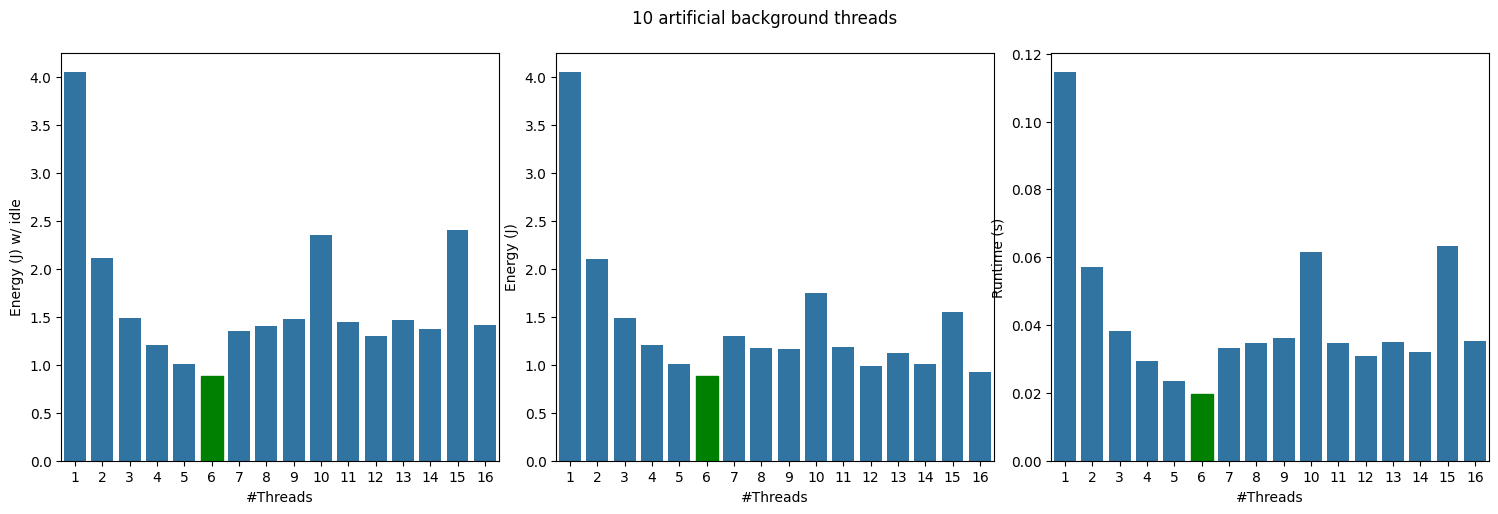

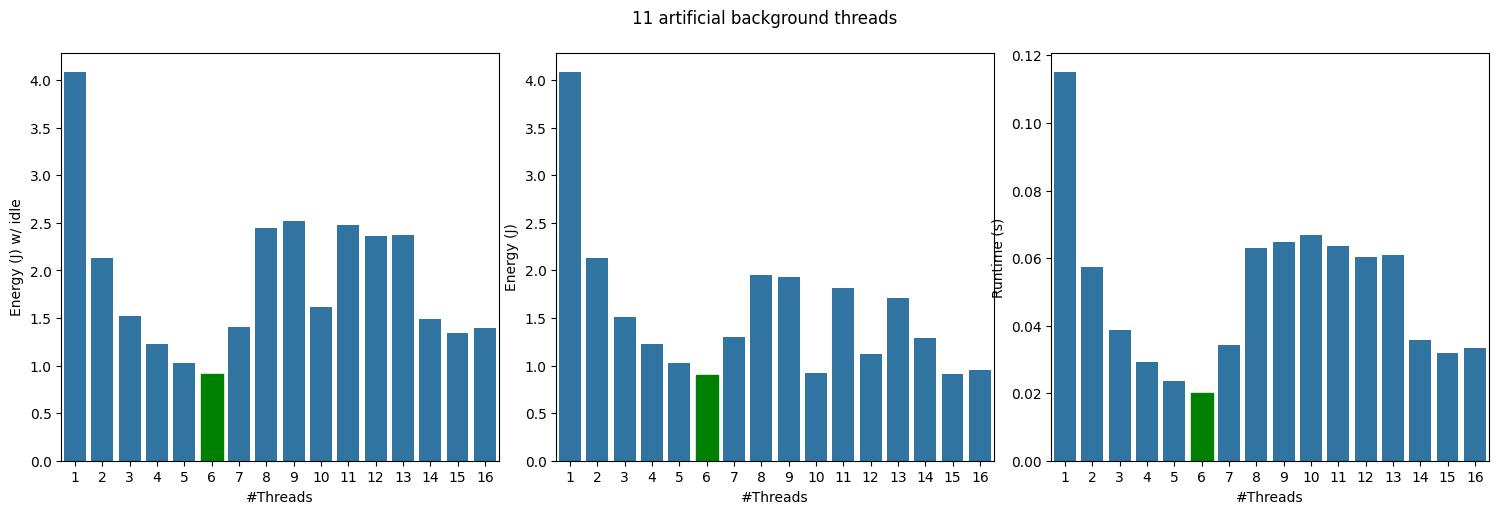

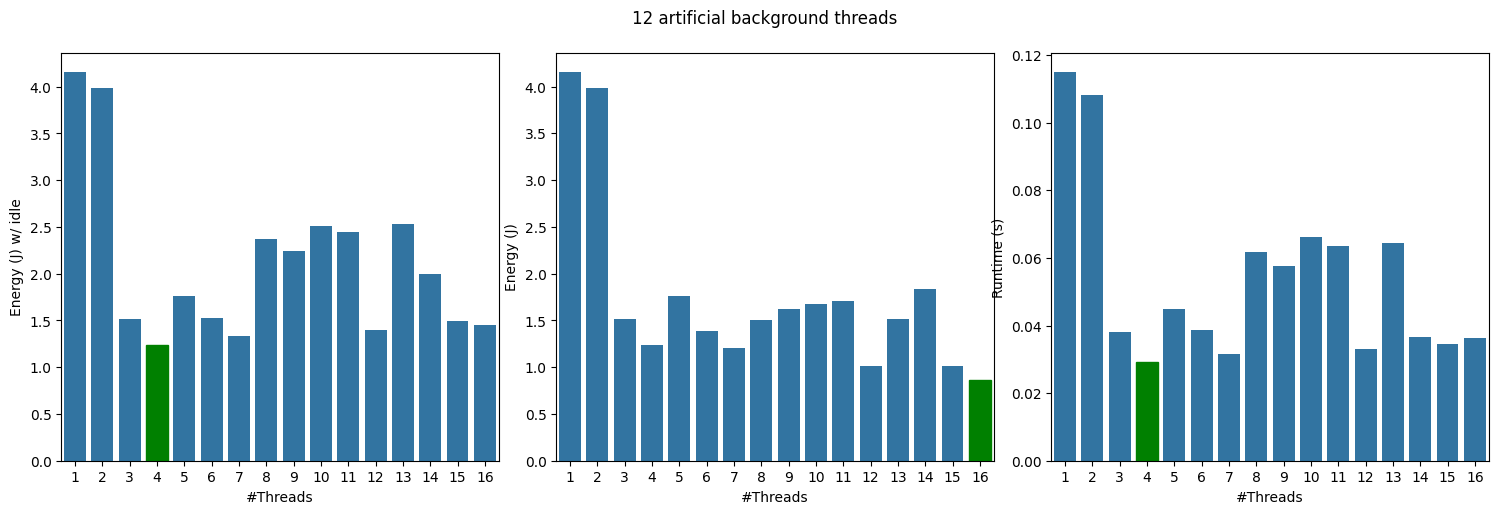

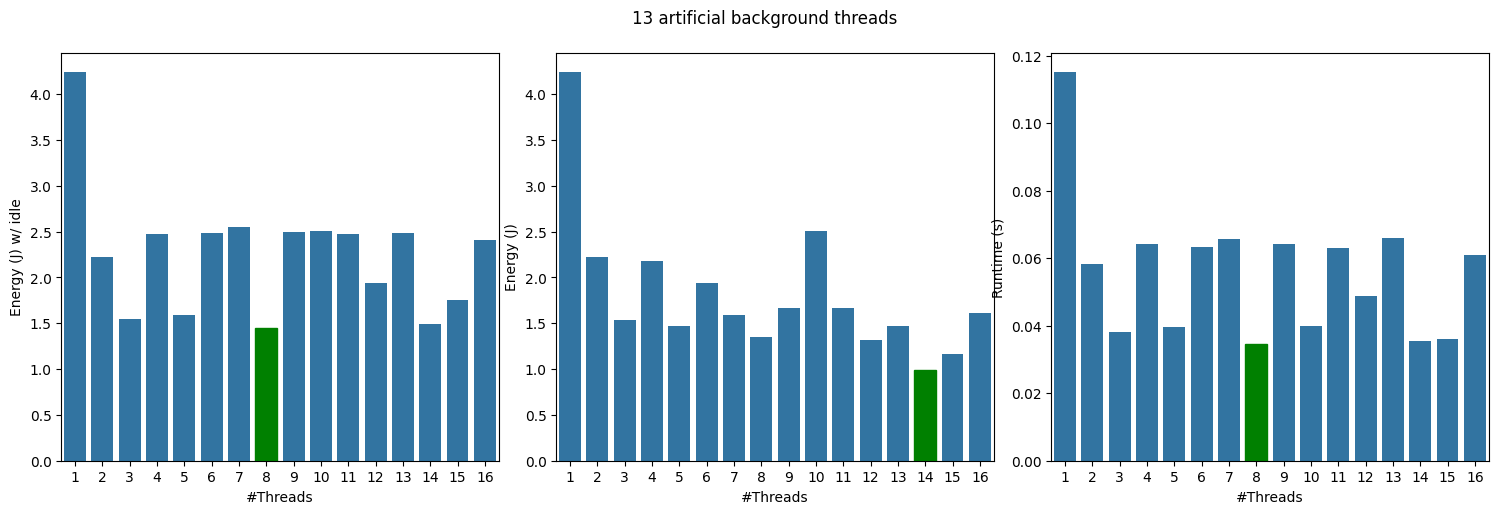

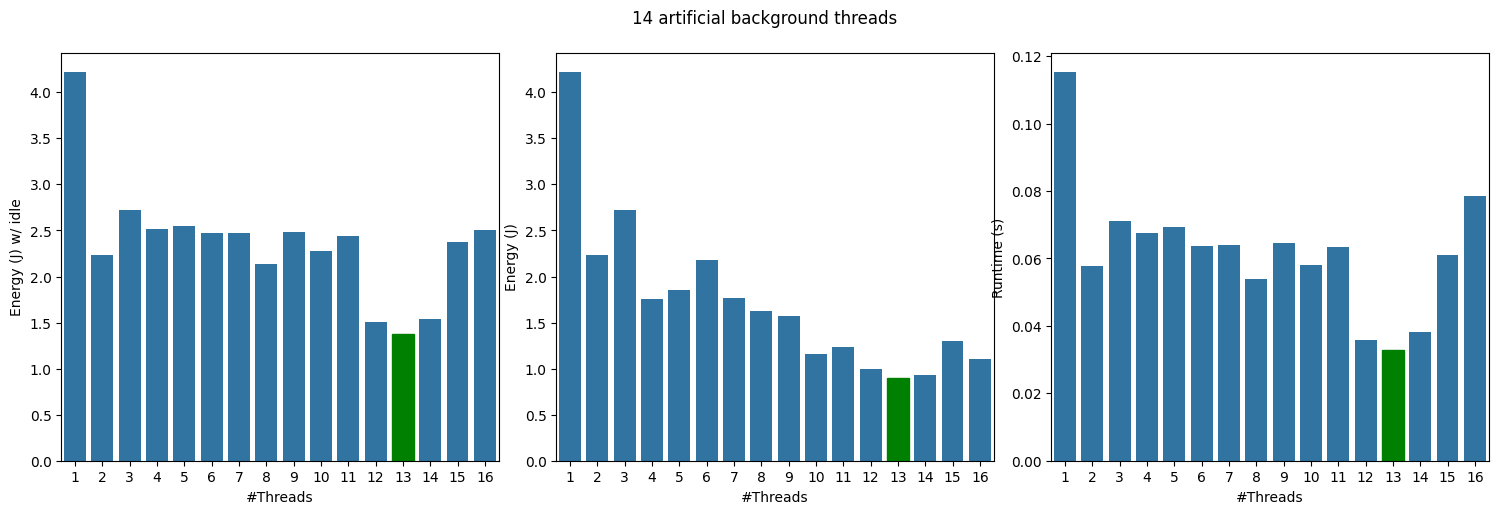

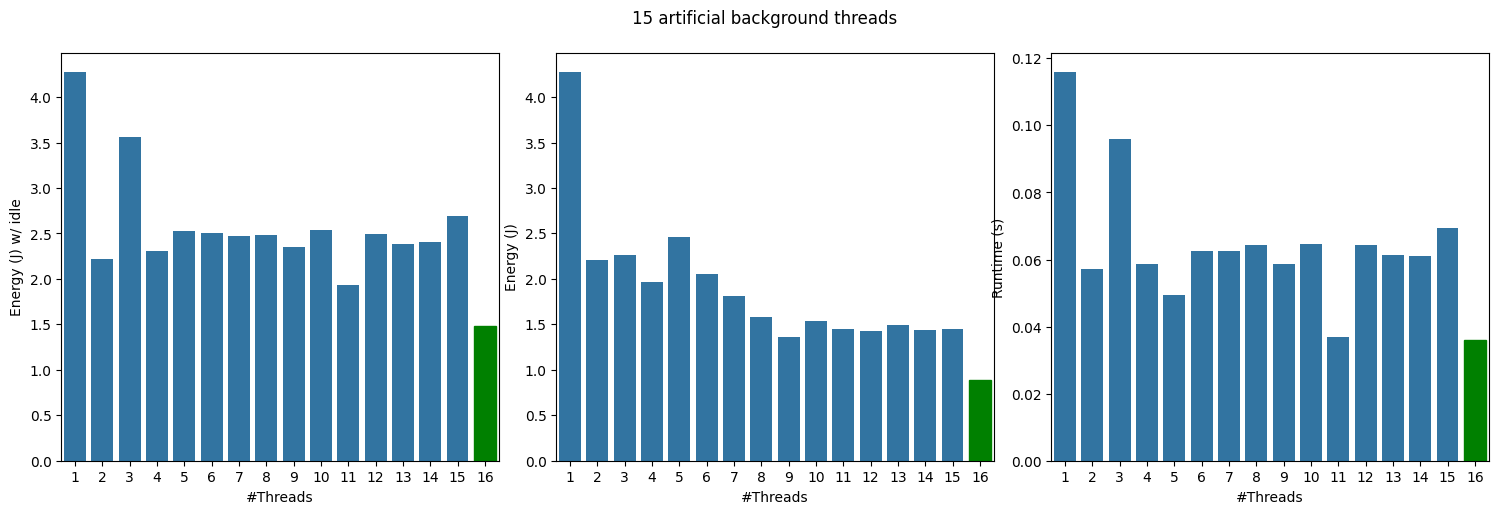

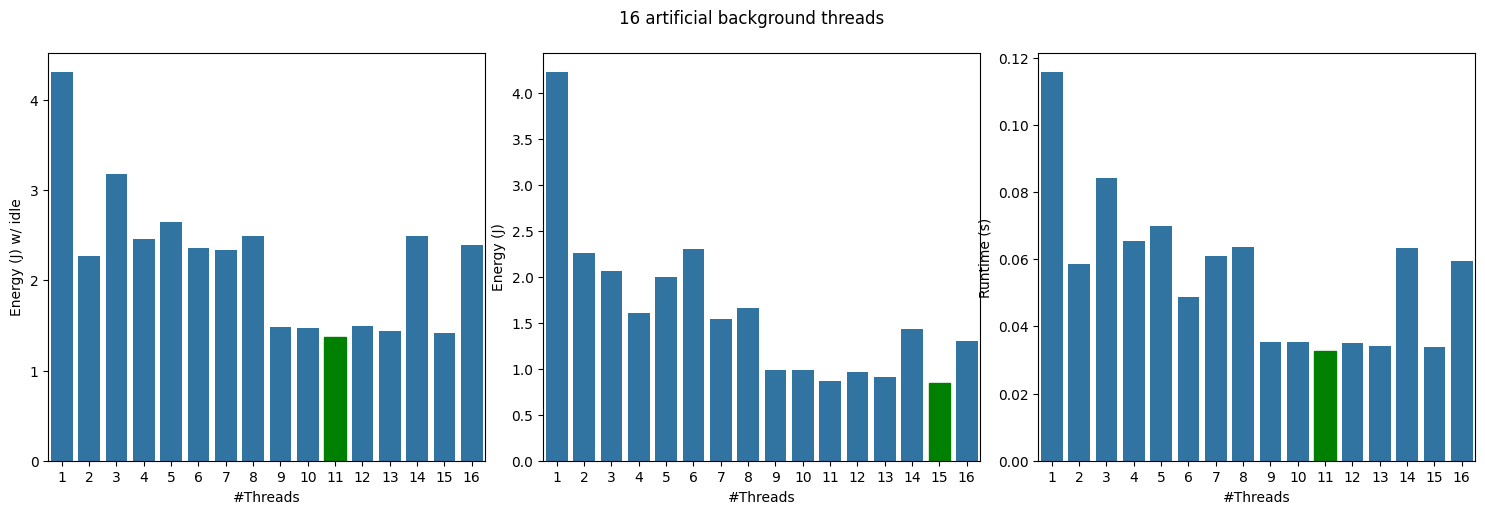

In [61]:
for busy in df['#Busy'].unique():
    dfx = df[df['#Busy'] == busy]
    
    fig, (ax_idle, ax_energy, ax_runtime) = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'{busy} artificial background threads')
    fig.tight_layout()

    sns.barplot(dfx, x='#Threads', y='Energy (J) w/ idle', ax=ax_idle)
    sns.barplot(dfx, x='#Threads', y='Energy (J)', ax=ax_energy)
    sns.barplot(dfx, x='#Threads', y='Runtime (s)', ax=ax_runtime)
    
    def color_best(ax, col):
        for bar in ax.patches:
            if bar.get_height() == dfx[col].min():
                bar.set_color('g')
                return
    color_best(ax_idle, 'Energy (J) w/ idle')
    color_best(ax_energy, 'Energy (J)')
    color_best(ax_runtime, 'Runtime (s)')
    
    plt.show()

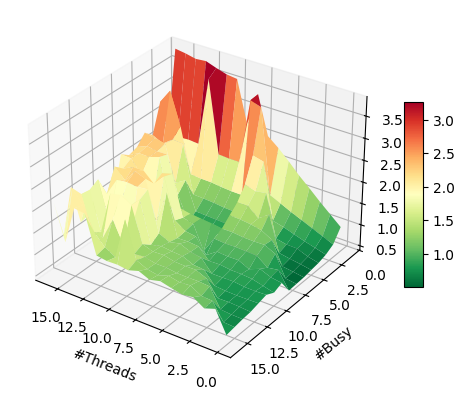

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

y1 = np.linspace(df['#Threads'].min(), df['#Threads'].max(), len(df['#Threads'].unique()))
x1 = np.linspace(df['#Busy'].min(), df['#Busy'].max(), len(df['#Busy'].unique()))

x2, y2 = np.meshgrid(x1, y1)

z2 = griddata((df['#Busy'], df['#Threads']), df['Energy (J)'], (x2, y2))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x2, y2, z2, cmap='RdYlGn_r')

fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_xlabel('#Threads')
ax.set_ylabel('#Busy')

ax.view_init(30, 125)

plt.show()

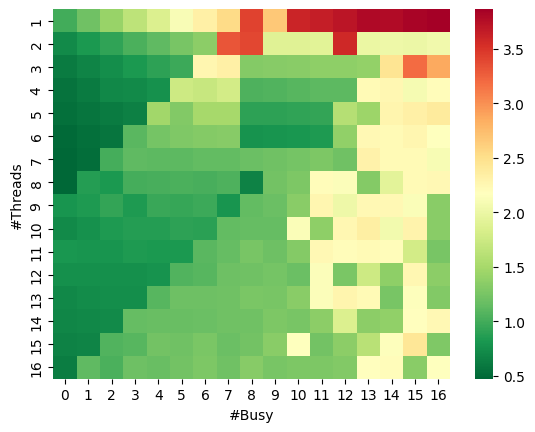

In [53]:
hm = df.pivot(index='#Threads', columns='#Busy', values='Energy (J)')
ax = sns.heatmap(hm, cmap='RdYlGn_r')
#ax.invert_yaxis()
plt.show()